# Predictive maintenance with classification models

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.ensemble import RandomForestClassifier

from timeit import default_timer as timer   # for measuring computation time
from pympler import asizeof                 # for measuring ML object size

# import self defined functions
from add_remaining_useful_life import add_remaining_useful_life

In [32]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

print(train.shape)

(20631, 26)


In [33]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()

,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [34]:
# adjust RUL value by truth values
for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_test['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


In [35]:
# add TTL (time to failure) variable
period = 30

train['label_bc'] = train['RUL'].apply(lambda y: 1 if y <= period else 0)
test['label_bc'] = test['RUL'].apply(lambda y: 1 if y <= period else 0) 
train.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


In [36]:
# use np arrays as input data type
# train_labels = np.array(train['cycle'])   
# test_labels = np.array(test['cycle']) 
train_labels = train['label_bc']  
test_labels = test['label_bc']


# remove cycle from datasets
train_features = train.drop(['cycle', 'id', 'setting1', 'setting2', 'setting3', 'RUL', 'label_bc'], axis=1)    
test_features = test.drop(['cycle', 'id', 'setting1', 'setting2', 'setting3', 'RUL', 'label_bc'], axis=1)

feature_list = list(train_features.columns)

## check data sizes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

train_features.head()
test_features.head()
train_labels.head()
test_labels.head()

Training Features Shape: (20631, 21)
Training Labels Shape: (20631,)
Testing Features Shape: (13096, 21)
Testing Labels Shape: (13096,)


0    0
1    0
2    0
3    0
4    0
Name: label_bc, dtype: int64

In [45]:
# define test and training features
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('label_bc')
X_test = test.groupby('id').last().reset_index().drop(drop_labels, axis=1)
X_test = X_test.drop('label_bc', axis=1)
X_train.drop('RUL', axis=1, inplace=True)
X_test.drop('RUL', axis=1, inplace=True)

,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117


The other method to predict the RUL is using classification models. In order to effectively use a classification method a proper feature has to be added. 
In this dataset, we classify if certain sensor values lead to a failure of a system. A failure is marked as 1, whereas a proper operation has 0 as its value. 
We also define a TTF (time to failure) time and a 'period' variable which defines the number of cycles left until RUL. 

## Random Forest as classification model

In [21]:
rf_clas = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=15)

# fit model
rf_clas.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
# predictions
train_label_bc = np.array(train['label_bc'])   # predicting cycle
test_label_bc = np.array(test['label_bc']) 
predictions = rf_clas.predict(test_features)
errors = abs(predictions - test_labels)

# Print out the mean absolute error
print('Mean Absolute Error:', round(np.mean(errors), 2))    # cannot compare regression/classification errors 

Mean Absolute Error: 0.01


In [25]:
print('Accuracy of model on test data: ',accuracy_score(test_label_bc, predictions))
print('Confusion Matrix: \n',confusion_matrix(test_label_bc, predictions))
test.head()

Accuracy of model on test data:  0.9866371411117899
Confusion Matrix: 
 [[12716    48]
 [  127   205]]


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


## KNN Model

In [ ]:
# find best number of neighbours
accuracy_n = np.zeros(50)
for n in range(1, accuracy_n.shape[0]):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit()

# Determining RUL 
The predictions result only in an array, which classifies if a certain set of sensor values qualifies as part of the class or not. 

<class 'pandas.core.frame.DataFrame'>
13096


,id,cycle,label_bc,failure
0,1,1,0,0.0
1,1,2,0,0.0
2,1,3,0,0.0
3,1,4,0,0.0
4,1,5,0,0.0


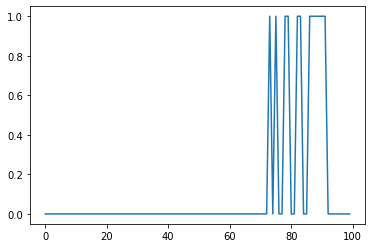

In [26]:
# plot prediction to get a better idea
prediction_data = test['id cycle'.split(' ')]
prediction_data['label_bc'] = predictions
# prediction_data['failure'] = 
# print(prediction_data['id'].max())
# print(len(prediction_data))
prediction_data['failure'] = np.zeros(len(prediction_data))

# print(prediction_data['id'][0])
# print(prediction_data['cycle'][13000])
# print(y_test['RUL'][currentID])
# print(prediction_data['failure'][13000])

# for i in range(0, 12999):
#     currentID = prediction_data['id'][i] - 1
#     if prediction_data['cycle'][i] == y_test['RUL'][currentID]:
#         prediction_data['failure'][i] = 1

print(type(prediction_data))
plt.plot(predictions[4500:4600])
# plt.plot(predictions)
# prediction_data.head()
y_test.head()
print(len(prediction_data))
# prediction_data['id'][400]
prediction_data.head()